#### Objective

Reconstruct a velocity log from density with optimized alpha and beta parameters for the Inverse Gardner function, found via `scipy.curve_fit`.

Original idea adapted from a notebook by Alessandro Amato del Monte so that it would work with Bruges' Inverse Gardner function.

The notebook accompanies [this blog post](https://mycarta.wordpress.com/2018/10/28/geophysics-python-sprint-2018-day-2-and-beyond-part-i/).

#### Required libraries and functions

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

#### Inverse Gardner function from AADM

In [2]:
def inv_gardner(rho, alpha, beta):
    return (rho/alpha)**(1/beta)

#### Agile's Gardner function

In [3]:
 def inverse_gardner(rho, alpha=310, beta=0.25, fps=False):
    """
    Computes Gardner's P-wave velocity prediction from density.
    Args:
        rho (ndarray): Density in kg/m^3.
        alpha (float): The factor, 310 for m/s and 230 for fps.
        beta (float): The exponent, usually 0.25.
        fps (bool): Set to true for FPS and the equation will use the typical
            value for alpha. Overrides value for alpha, so if you want to use
            your own alpha, regardless of units, set this to False.
        Returns:
            ndarray: Vp estimate in m/s.
    """
    alpha = 230 if fps else alpha
    exponent = 1 / beta
    factor = 1 / alpha**exponent
    return factor * rho**exponent
        

Tesing they give same result

In [4]:
inv_gardner(2000, 0.39, 0.23)

1.349846231542594e+16

In [5]:
inverse_gardner(2000, 0.39, 0.23)

1.3498462315425942e+16

#### Make up some random velocity and density using direct Gardner

In [6]:
def gardner(vp, alpha=310, beta=0.25, fps=False):
    """
    Computes Gardner's density prediction from P-wave velocity.
    Args:
        vp (ndarray): P-wave velocity in m/s.
        alpha (float): The factor, 310 for m/s and 230 for ft/s.
        beta (float): The exponent, usually 0.25.
        fps (bool): Set to true for FPS and the equation will use the typical
            value for alpha. Overrides value for alpha, so if you want to use
            you own alpha, regardless of units, set this to False.
    Returns:
        ndarray: RHOB estimate in kg/m^3.
    """
    alpha = 230 if fps else alpha
    return alpha * vp ** beta

In [7]:
# test
print(310*3000**0.25)
print(gardner(3000, 310, 0.25))

2294.256693926084
2294.256693926084


In [8]:
vp_test=np.linspace(1500, 5500)
#rho_test=(0.31*vp_test**0.25) 
rho_test=gardner(vp_test, 310, 0.25)
noise=np.random.uniform(0.1,0.3,vp_test.shape)*1000
#rho_test = (rho_test + noise )*1000
rho_test += noise

#### Split both density and velocity into an array for fitting for alpha and beta, and one for calculating "unknown" velocities

In [13]:
idx = np.arange(len(vp_test))
np.random.seed(3)
spl1 = np.random.randint(0, len(vp_test), 15)
spl2 = np.setxor1d(idx,spl1)
vp1= vp_test[spl1] # this we pretend we do not have, we use at the end to validate the calculation, 
                         #to ensure it works as expected
vp2= vp_test[spl2]
rho1 = rho_test[spl1]
rho2 = rho_test[spl2]

#### Pass simple inverse Gardner function to curve_fit to find optimal alpha and beta parameters

In [17]:
popt_synt2, pcov2 = curve_fit(inverse_gardner, rho2, vp2)
print (popt_synt2)

[1.         0.29525991 1.        ]


/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [18]:
popt_synt2, pcov2 = curve_fit(inv_gardner,rho2,vp2)
print (popt_synt2)

[3.31376056e+02 2.51257203e-01]


#### Use those optimal alpha and beta as parameters to calculate vp from density using simple inverse Gardner function

In [19]:
vp_calc1 = inv_gardner(rho1, *popt_synt2)

#### Plot to check results of calculation

In [20]:
rho_synt_fit=np.linspace(1, 3000, 50)
vp_synt_fit=inv_gardner(rho_synt_fit, *popt_synt2)

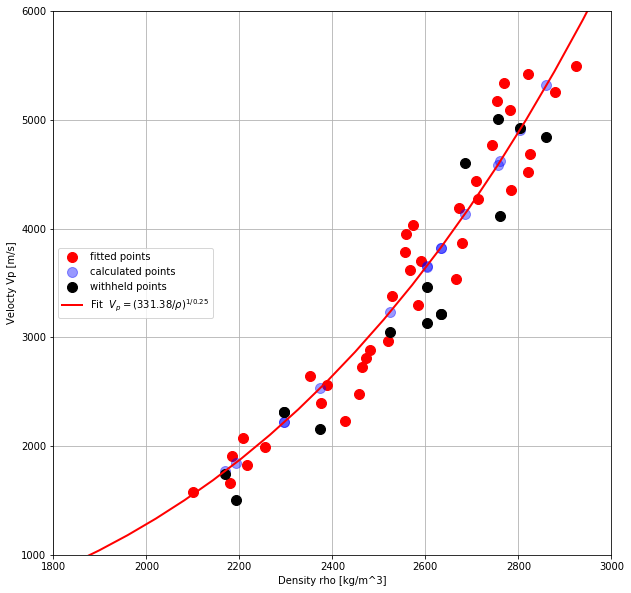

In [30]:
plt.figure(figsize=(10,10))
plt.plot(rho2,vp2,'or', markersize = 10, label = "fitted points")                   # this is the data used for fitting
plt.plot(rho1,vp_calc1,'ob', markersize = 10, alpha = 0.4, label = "calculated points")  # this is calculated vp
plt.plot(rho1,vp1,'ok', markersize = 10, label = "withheld points")               # this is the validation data
plt.plot(rho_synt_fit, vp_synt_fit, '-r', lw=2, 
         label='Fit  ' r'$ V_p = (%.2f / \rho)^{1/%.2f}$' % (popt_synt2[0], 
                                                     popt_synt2[1]))
plt.xlabel('Density rho [kg/m^3]'), plt.xlim(1800,3000)
plt.ylabel('Velocty Vp [m/s]'), plt.ylim(1000,6000)
plt.grid()
plt.legend(loc='center left')
plt.savefig('plot.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


#### Optimizer wrapper that will map between the call signature of curve_fit and the call signature of Agile's inverse_gardner so the latter can be passed to curve_fit 

In [31]:
def optimize_inverse_gardner(rho, alpha, beta):
    return inverse_gardner(rho, alpha=alpha, beta=beta)

#### Test we get the same result

In [32]:
popt_synt2, pcov2 = scipy.curve_fit(optimize_inverse_gardner, 
                                    rho2, vp2) 
print (popt_synt2)

[3.31376060e+02 2.51257202e-01]


#### Success!!